### Import standard modules


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

### Initialize standard logger

In [2]:
import logging

logging.basicConfig(format="%(asctime)s.%(msecs)03d %(levelname)-8s %(message)s",
                    datefmt="%Y-%m-%d %H:%M:%S",
                    level=logging.INFO)

### Create the Simulation State

There are 2 objects that hold the state of the simulation:
  1. *Population* is a container for the state each persion
  2. *Society* is the state of the government, eg the testing processes

In [3]:
from codit.society import Society
from codit.population.covid import PersonCovid
from codit.population.networks.city import CityPopulation
from codit.population.networks.city_config.city_cfg import city_paras
from codit.society.alternatives import UKSociety

In [4]:
POPULATION_SIZE = city_paras["Leeds"]['population']

In [5]:
# Most classrooms and workplaces are closed
LOCKDOWN_CFG = dict(classrooms=0.66, workplaces=0.66, ephemeral_contact=0.0)

# We assume that Covid survivors, and the vaccinated, have an 80% chance of catching and passing on the disease another time:
X_IMMUNITY=0.8
# However this factor is square for the indian variant (and 80% squared is 64%)

pop = CityPopulation(POPULATION_SIZE, Society(config=dict(X_IMMUNITY=X_IMMUNITY)), 
                     person_type=PersonCovid, lockdown_config=LOCKDOWN_CFG)

SOCIETY_CFG = dict(DAILY_TEST_CAPACITY_PER_HEAD=0.01, 
                   PROB_APPLY_FOR_TEST_IF_SYMPTOMS=0.25)

soc = UKSociety(config=SOCIETY_CFG)

2021-05-16 20:20:14.972 INFO     Building a set of 31725 households from which to build a population
2021-05-16 20:20:20.748 INFO     30201 households of mean size 2.63
2021-05-16 20:20:21.091 INFO     15665 buildings of mean size 5.06
2021-05-16 20:20:24.236 INFO     274 classrooms of mean size 21.58
2021-05-16 20:20:24.276 INFO     18 care_homes of mean size 104.72
2021-05-16 20:20:24.539 INFO     9337 workplaces of mean size 5.60
2021-05-16 20:20:24.764 INFO     66.0% of workplaces closed by lockdown, leaving 3351 open, of average Income Decile 4.96 (and st dev 3.12).
2021-05-16 20:20:24.785 INFO     66.0% of classrooms closed by lockdown, leaving 94 open, of average Income Decile 4.53 (and st dev 3.04).
2021-05-16 20:20:24.790 INFO     Adding 33664 permanent contact groups
2021-05-16 20:20:24.791 INFO     Adding 0 ephemeral contact pairs
2021-05-16 20:20:24.895 INFO     Adding 23165 contacts each within one of the 15665 buildings (contact density of 0.75)


### Create the 2 variants

In [6]:
from codit.disease import Covid

kent_variant = Covid(name="B.1.1.7")
indian_variant = Covid(name="B.1.617.2")

### Burn in the simulation

In [7]:
from codit.outbreak import Outbreak

BURNIN_DAYS = 30
WINTER_PREVALENCE = 1/40
SEED_SIZE = int(POPULATION_SIZE * WINTER_PREVALENCE)

o_burnin = Outbreak(soc, kent_variant, n_days=BURNIN_DAYS, seed_size=SEED_SIZE, population=pop)
o_burnin.simulate()

2021-05-16 20:20:27.819 INFO     Day 1, prop infected is 0.03, prop infectious is 0.0179
2021-05-16 20:20:41.583 INFO     Day 30, prop infected is 0.13, prop infectious is 0.0200


### Run the simulation for January and February

2021-05-16 20:20:46.360 INFO     Day 1, prop infected is 0.13, prop infectious is 0.0200
2021-05-16 20:21:08.050 INFO     Day 51, prop infected is 0.20, prop infectious is 0.0035
2021-05-16 20:21:11.154 INFO     Day 60, prop infected is 0.20, prop infectious is 0.0022
2021-05-16 20:21:11.361 INFO      Realized R0 of early infections is 0.92
2021-05-16 20:21:11.362 INFO      20.0 percent of the population was infected during the epidemic


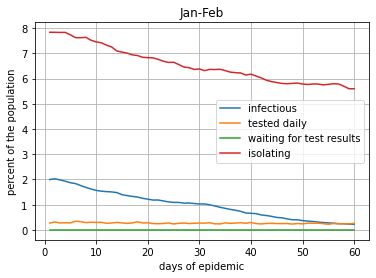

In [8]:
from codit.outbreak_recorder import WardComponent

DAYS_MONTH = 30

o_Jan_Feb = Outbreak(soc, n_days=DAYS_MONTH * 2, population=pop, reset_population=False)
o_Jan_Feb.recorder.add_component(WardComponent(o_Jan_Feb))
o_Jan_Feb.simulate()
o_Jan_Feb.recorder.plot(title="Jan-Feb")

### March 
  1. Open classrooms
  2. People now 'brush past' on average 0.3 others randomly per day (see COMIX)
  3. Vaccinate the over 60s

In [9]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.66, ephemeral_contact=0.3)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)
pop.clear_memory()

for i, p in enumerate(pop.people):
    if p.age > 60 and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with("AstraZeneca")

2021-05-16 20:21:11.920 INFO     66.0% of workplaces closed by lockdown, leaving 3244 open, of average Income Decile 4.96 (and st dev 3.12).
2021-05-16 20:21:11.941 INFO     0.0% of classrooms closed by lockdown, leaving 227 open, of average Income Decile 4.86 (and st dev 3.09).
2021-05-16 20:21:11.947 INFO     Adding 33690 permanent contact groups
2021-05-16 20:21:11.978 INFO     Adding 11897 ephemeral contact pairs
2021-05-16 20:21:12.076 INFO     Adding 23209 contacts each within one of the 15665 buildings (contact density of 0.75)


In [10]:
from codit.society.lateral import LateralFlowUK
lat_flow_soc = LateralFlowUK(config=SOCIETY_CFG)

2021-05-16 20:21:13.134 INFO     The city has 20x the number of lateral flow tests available, as PCRs


2021-05-16 20:21:17.844 INFO     Setting mass testing valency/degree limit to 22
2021-05-16 20:21:19.000 INFO     Day 1, prop infected is 0.20, prop infectious is 0.0021
2021-05-16 20:21:41.207 INFO     Day 30, prop infected is 0.21, prop infectious is 0.0014
2021-05-16 20:21:41.604 INFO      Realized R0 of early infections is 0.92
2021-05-16 20:21:41.607 INFO      20.6 percent of the population was infected during the epidemic


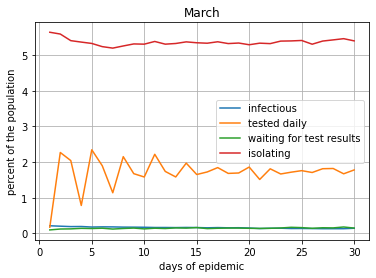

In [11]:
o_March = Outbreak(lat_flow_soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_March.recorder.add_component(WardComponent(o_March))
o_March.simulate()
o_March.recorder.plot(title="March")

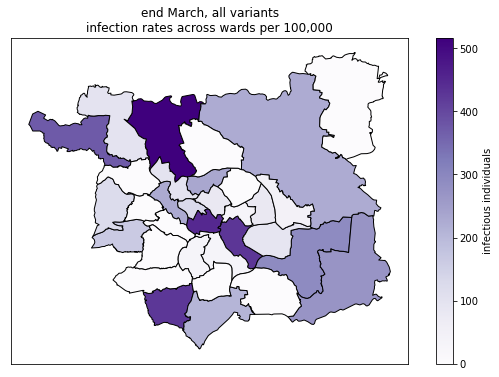

In [12]:
plt.rcParams["figure.figsize"] = [10, 6]
r = o_March.recorder.components[-1]
r.map_incidence(r.infectious, title='end March, all variants', end_date=True, per_hundred_k=True)

### April
    1. More workplaces (such as non-essential retail) open up
    2. More people brush past each other as restrictions are lifted
    3. 10 people introduce the Indian variant into the Leeds population
    4. Vaccinate the over 50s

In [13]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.5, ephemeral_contact=0.4)

pop.set_structure(lat_flow_soc, lockdown_config=LOCKDOWN_CFG)

2021-05-16 20:21:42.747 INFO     50.0% of workplaces closed by lockdown, leaving 4715 open, of average Income Decile 4.97 (and st dev 3.13).
2021-05-16 20:21:42.768 INFO     0.0% of classrooms closed by lockdown, leaving 233 open, of average Income Decile 4.95 (and st dev 3.09).
2021-05-16 20:21:42.773 INFO     Adding 35167 permanent contact groups
2021-05-16 20:21:42.805 INFO     Adding 15862 ephemeral contact pairs
2021-05-16 20:21:42.907 INFO     Adding 23170 contacts each within one of the 15665 buildings (contact density of 0.75)


In [14]:
from codit.population.population import seed_infection

chapel_residents = [p for p in pop.people if 'Chapel' in p.home.ward.name]
ca, = {p.home.ward.name for p in chapel_residents}
logging.info(f"Seeding 30 infections of the Indian Variant in {ca}")
seed_infection(30, chapel_residents, indian_variant)

2021-05-16 20:21:44.128 INFO     Seeding 30 infections of the Indian Variant in Chapel Allerton


In [15]:
for i, p in enumerate(pop.people):
    if (60 >= p.age > 50) and i % 20: # vaccinate 19 in every 20 people
        p.vaccinate_with("AstraZeneca")

In [16]:
pop.clear_memory()

2021-05-16 20:21:51.171 INFO     Day 1, prop infected is 0.21, prop infectious is 0.0016
2021-05-16 20:22:13.939 INFO     Day 30, prop infected is 0.21, prop infectious is 0.0021
2021-05-16 20:22:14.102 INFO      Realized R0 of early infections is 1.10
2021-05-16 20:22:14.103 INFO      21.4 percent of the population was infected during the epidemic


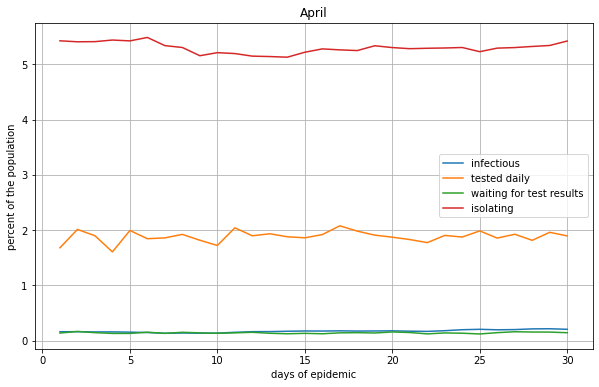

In [17]:
o_April = Outbreak(lat_flow_soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_April.recorder.add_component(WardComponent(o_April))
o_April.simulate()
o_April.recorder.plot(title="April")

### April surge vaccination in Chapel Allerton:

In [18]:
for i, p in enumerate(chapel_residents):
    if (45 >= p.age > 18) and i % 5: # vaccinate 4 in every 5 young people
        p.vaccinate_with("AstraZeneca")

In [19]:
infected_wards = [p.home.ward for p in pop.people if p.disease == indian_variant]
print(f"{len(infected_wards)} cases of the Indian Variant:")
counts = {x.name: infected_wards.count(x) for x in infected_wards}
for k, v in counts.items():
    print(f"{v} in {k}")

90 cases of the Indian Variant:
15 in Chapel Allerton
21 in Burmantofts & Richmond Hill
3 in Alwoodley
3 in Morley North
2 in Ardsley & Robin Hood
3 in Middleton Park
2 in Weetwood
3 in Gipton & Harehills
5 in Calverley & Farsley
2 in Roundhay
1 in Headingley & Hyde Park
2 in Beeston & Holbeck
2 in Horsforth
2 in Farnley & Wortley
1 in Temple Newsam
4 in Garforth & Swillington
3 in Pudsey
1 in Kippax & Methley
1 in Little London & Woodhouse
3 in Hunslet & Riverside
1 in Wetherby
7 in Morley South
1 in Cross Gates & Whinmoor
1 in Adel & Wharfedale
1 in Moortown


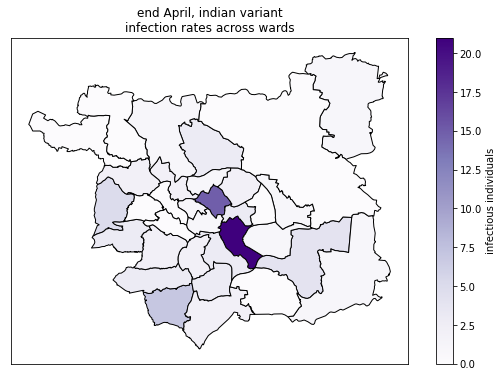

In [20]:
r = o_April.recorder.components[-1]
r.map_incidence(r.indian_variant, title='end April, indian variant', end_date=True)

### May
    1. Even more workplaces open up
    2. More people brush past on average 0.5 others randomly per day


In [21]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.33, ephemeral_contact=0.5)
pop.clear_memory()
pop.set_structure(lat_flow_soc, lockdown_config=LOCKDOWN_CFG)

for i, p in enumerate(pop.people):
    if (50 >= p.age > 45) and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with("AstraZeneca")

2021-05-16 20:22:15.947 INFO     33.0% of workplaces closed by lockdown, leaving 6129 open, of average Income Decile 4.99 (and st dev 3.12).
2021-05-16 20:22:15.971 INFO     0.0% of classrooms closed by lockdown, leaving 223 open, of average Income Decile 4.78 (and st dev 3.04).
2021-05-16 20:22:15.975 INFO     Adding 36571 permanent contact groups
2021-05-16 20:22:16.667 INFO     Adding 19828 ephemeral contact pairs
2021-05-16 20:22:16.765 INFO     Adding 23133 contacts each within one of the 15665 buildings (contact density of 0.75)


2021-05-16 20:22:22.450 INFO     Day 1, prop infected is 0.21, prop infectious is 0.0020
2021-05-16 20:22:49.248 INFO     Day 30, prop infected is 0.22, prop infectious is 0.0014
2021-05-16 20:22:49.428 INFO      Realized R0 of early infections is 0.98
2021-05-16 20:22:49.429 INFO      22.0 percent of the population was infected during the epidemic


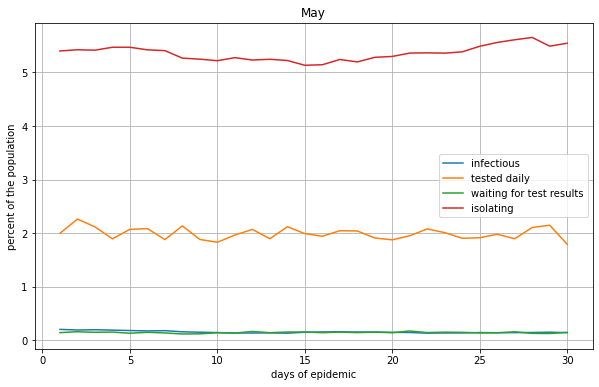

In [22]:
o_May = Outbreak(lat_flow_soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_May.recorder.add_component(WardComponent(o_May))
o_May.simulate()
o_May.recorder.plot(title="May")

In [23]:
infected_wards = [p.home.ward for p in pop.people if p.disease == indian_variant]
print(f"{len(infected_wards)} cases of the Indian Variant:")
counts = {x.name: infected_wards.count(x) for x in infected_wards}
for k, v in counts.items():
    print(f"{v} in {k}")

83 cases of the Indian Variant:
11 in Garforth & Swillington
16 in Little London & Woodhouse
2 in Guiseley & Rawdon
1 in Temple Newsam
8 in Burmantofts & Richmond Hill
6 in Ardsley & Robin Hood
3 in Cross Gates & Whinmoor
2 in Headingley & Hyde Park
2 in Hunslet & Riverside
6 in Otley & Yeadon
2 in Kirkstall
1 in Roundhay
1 in Weetwood
3 in Middleton Park
2 in Wetherby
1 in Farnley & Wortley
1 in Horsforth
2 in Gipton & Harehills
1 in Calverley & Farsley
3 in Morley North
5 in Alwoodley
1 in Pudsey
2 in Moortown
1 in Kippax & Methley


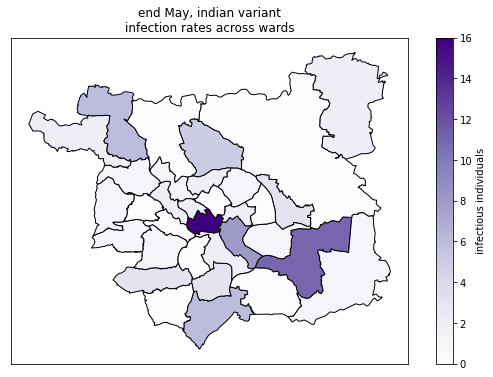

In [24]:
r = o_May.recorder.components[-1]
r.map_incidence(r.indian_variant, title='end May, indian variant', end_date=True)

In [25]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.33, ephemeral_contact=0.5)
pop.clear_memory()
pop.set_structure(lat_flow_soc, lockdown_config=LOCKDOWN_CFG)

for i, p in enumerate(pop.people):
    if (45 >= p.age > 35) and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with("AstraZeneca")

2021-05-16 20:22:50.570 INFO     33.0% of workplaces closed by lockdown, leaving 6105 open, of average Income Decile 4.99 (and st dev 3.12).
2021-05-16 20:22:50.593 INFO     0.0% of classrooms closed by lockdown, leaving 223 open, of average Income Decile 4.78 (and st dev 3.05).
2021-05-16 20:22:50.598 INFO     Adding 36547 permanent contact groups
2021-05-16 20:22:50.732 INFO     Adding 19828 ephemeral contact pairs
2021-05-16 20:22:50.851 INFO     Adding 23226 contacts each within one of the 15665 buildings (contact density of 0.75)


2021-05-16 20:22:57.977 INFO     Day 1, prop infected is 0.22, prop infectious is 0.0014
2021-05-16 20:23:21.132 INFO     Day 30, prop infected is 0.22, prop infectious is 0.0009
2021-05-16 20:23:21.302 INFO      Realized R0 of early infections is 0.85
2021-05-16 20:23:21.303 INFO      22.5 percent of the population was infected during the epidemic


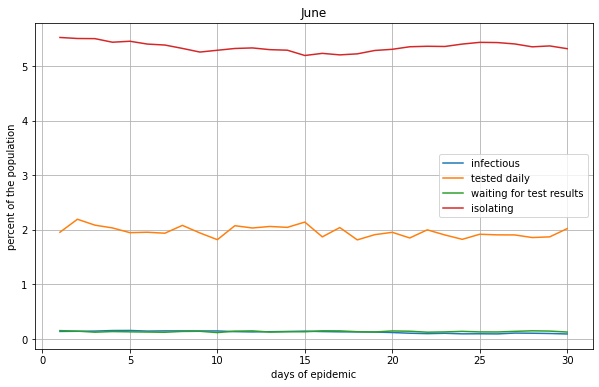

In [26]:
o_June = Outbreak(lat_flow_soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_June.recorder.add_component(WardComponent(o_May))
o_June.simulate()
o_June.recorder.plot(title="June")

In [27]:
infected_wards = [p.home.ward for p in pop.people if p.disease == indian_variant]
print(f"{len(infected_wards)} cases of the Indian Variant:")
counts = {x.name: infected_wards.count(x) for x in infected_wards}
for k, v in counts.items():
    print(f"{v} in {k}")

65 cases of the Indian Variant:
1 in Armley
2 in Morley North
2 in Ardsley & Robin Hood
12 in Beeston & Holbeck
1 in Hunslet & Riverside
1 in Moortown
15 in Cross Gates & Whinmoor
2 in Headingley & Hyde Park
1 in Calverley & Farsley
1 in Kippax & Methley
4 in Middleton Park
9 in Rothwell
1 in Burmantofts & Richmond Hill
2 in Horsforth
1 in Farnley & Wortley
2 in Weetwood
1 in Pudsey
1 in Chapel Allerton
1 in Kirkstall
5 in Wetherby


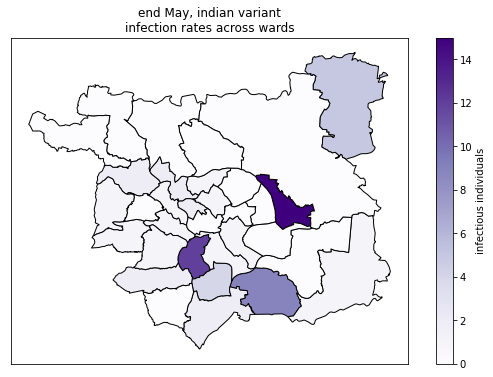

In [28]:
r = o_June.recorder.components[-1]
r.map_incidence(r.indian_variant, title='end May, indian variant', end_date=True)